# Faster Polynomial Features

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Polynomial Features

The current implementation of [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) (0.20.2) implements a term by term product for each pair $X_i, X_j$ of features where $i \leqslant j$ which is not the most efficient way to do it.

In [3]:
import numpy.random
X = numpy.random.random((100, 5))

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [5]:
%timeit poly.transform(X)

114 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The class [ExtendedFeatures](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mlmodel/extended_features.html) implements a different way to compute the polynomial features as it tries to reduce the number of calls to numpy by using broacasted vector multplications.

In [6]:
from mlinsights.mlmodel import ExtendedFeatures
ext = ExtendedFeatures(poly_degree=2)
Xpoly = ext.fit_transform(X)
ext.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [7]:
%timeit ext.transform(X)

68.7 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Comparison with 5 features

In [8]:
from cpyquickhelper.numbers import measure_time

In [9]:
res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=10, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=10, div_by_number=True)
    r3 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=10, div_by_number=True)
    r4 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=10, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "poly+fit"
    r4["name"] = "ext+fit"
    r1["size"] = n
    r2["size"] = n
    r3["size"] = n
    r4["size"] = n
    res.append(r1)
    res.append(r2)
    res.append(r3)
    res.append(r4)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,deviation,min_exec,max_exec,repeat,number,context_size,name,size
63,0.037830,0.005577,0.031248,0.044832,5,10,240,ext+fit,100000
64,0.072671,0.005360,0.067559,0.082539,5,10,240,poly,200000
65,0.075712,0.018271,0.060476,0.100143,5,10,240,ext,200000
66,0.106755,0.019861,0.079880,0.139184,5,10,240,poly+fit,200000
67,0.074090,0.009142,0.063925,0.085899,5,10,240,ext+fit,200000


In [10]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,ext+fit,poly,poly+fit
size,,,,
1,0.000068,0.000402,0.000238,0.000275
2,0.000066,0.000156,0.000166,0.000213
5,0.000031,0.000427,0.000165,0.000196
10,0.000048,0.000237,0.000134,0.000306
20,0.000070,0.000188,0.000109,0.000153


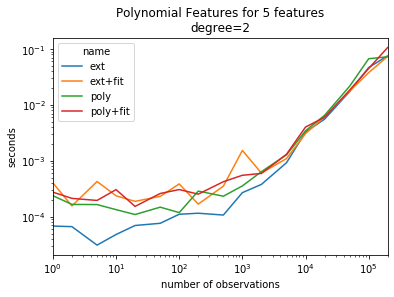

In [11]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree=2")
ax.set_ylabel("seconds")
ax.set_xlabel("number of observations");

The gain is mostly visible for small dimensions.

## Comparison with 1000 observations

In this experiment, the number of observations is fixed to 1000 but the number of features varies.

In [12]:
poly = PolynomialFeatures(degree=2)
ext = ExtendedFeatures(poly_degree=2)
# implementation of PolynomialFeatures in 0.20.2
extslow = ExtendedFeatures(poly_degree=2, kind="poly-slow") 


res = []
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 40, 50]:
    X = numpy.random.random((1000, n))
    poly.fit(X)
    ext.fit(X)
    extslow.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30, div_by_number=True)
    r3 = measure_time("extslow.transform(X)", context=dict(X=X, extslow=extslow), repeat=5, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "extslow"
    r1["nfeat"] = n
    r2["nfeat"] = n
    r3["nfeat"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    x3 = extslow.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    r3["numf"] = x3.shape[1]
    res.append(r1)
    res.append(r2)
    res.append(r3)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,deviation,min_exec,max_exec,repeat,number,context_size,name,nfeat,numf
37,0.009331,0.001603,0.008280,0.012519,5,30,240,ext,40,861
38,0.022619,0.002868,0.018793,0.026324,5,30,240,extslow,40,861
39,0.013188,0.000370,0.012828,0.013888,5,30,240,poly,50,1326
40,0.012817,0.000102,0.012700,0.012951,5,30,240,ext,50,1326
41,0.030384,0.000717,0.029955,0.031813,5,30,240,extslow,50,1326


In [13]:
piv = df.pivot("nfeat", "name", "average")
piv[:5]

name,ext,extslow,poly
nfeat,,,
1,0.000026,0.000059,0.000152
2,0.000055,0.000100,0.000113
3,0.000161,0.000381,0.000237
4,0.000148,0.000221,0.000219
5,0.000185,0.000340,0.000236


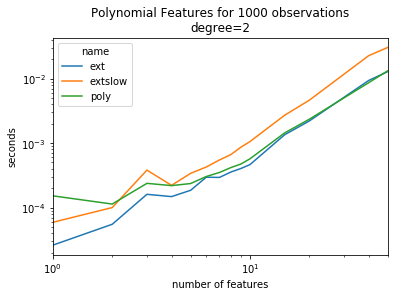

In [14]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\ndegree=2")
ax.set_ylabel("seconds")
ax.set_xlabel("number of features");

It is twice faster.

## Comparison for different degrees

In this experiment, the number of observations and features is fixed, the degree increases.

In [15]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8]:
    X = numpy.random.random((1000, 4))
    poly = PolynomialFeatures(degree=n)
    ext = ExtendedFeatures(poly_degree=n)
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["degree"] = n
    r2["degree"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,deviation,min_exec,max_exec,repeat,number,context_size,name,degree,numf
9,0.001960,0.000067,0.001915,0.002094,5,30,240,ext,6,210
10,0.003131,0.000118,0.003009,0.003327,5,30,240,poly,7,330
11,0.003076,0.000233,0.002845,0.003393,5,30,240,ext,7,330
12,0.004299,0.000046,0.004243,0.004367,5,30,240,poly,8,495
13,0.004157,0.000035,0.004114,0.004217,5,30,240,ext,8,495


In [16]:
piv = df.pivot("degree", "name", "average")
piv[:5]

name,ext,poly
degree,,
2,0.000140,0.000312
3,0.000304,0.000363
4,0.000506,0.000579
5,0.000715,0.000789
6,0.001960,0.002032


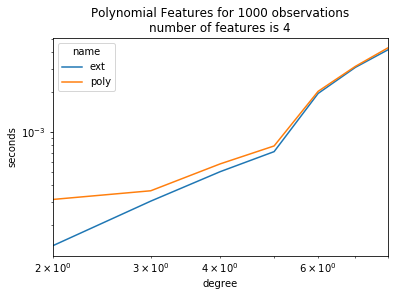

In [17]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\nnumber of features is 4")
ax.set_ylabel("seconds")
ax.set_xlabel("degree");

It is worth transposing.

## Same experiment with interaction_only=True

In [18]:
res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    ext = ExtendedFeatures(poly_degree=2, poly_interaction_only=True)
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=2, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=2, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["size"] = n
    r2["size"] = n
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,deviation,min_exec,max_exec,repeat,number,context_size,name,size
29,0.010691,0.000073,0.010618,0.010764,2,30,240,ext,50000
30,0.026612,0.000794,0.025817,0.027406,2,30,240,poly,100000
31,0.025052,0.001583,0.023469,0.026635,2,30,240,ext,100000
32,0.058772,0.001345,0.057427,0.060118,2,30,240,poly,200000
33,0.054771,0.004555,0.050216,0.059327,2,30,240,ext,200000


In [19]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,poly
size,,
1,0.000042,0.000086
2,0.000034,0.000104
5,0.000068,0.000089
10,0.000032,0.000092
20,0.000040,0.000103


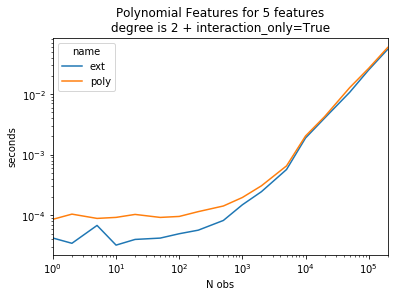

In [20]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree is 2 + interaction_only=True")
ax.set_ylabel("seconds")
ax.set_xlabel("N obs");

## Memory profiler

In [21]:
from memory_profiler import memory_usage
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit(X)
memory_usage((poly.transform, (X,)), interval=0.1, max_usage=True)

258.02734375

In [22]:
def pick_value(v):
    try:
        return v[0]
    except TypeError:
        return v

res = []
for n in [10000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 50))
    print(n)
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    ext = ExtendedFeatures(poly_degree=2, poly_interaction_only=True)
    poly.fit(X)
    ext.fit(X)
    r1 = memory_usage((poly.transform, (X,)), interval=0.1, max_usage=True)
    r2 = memory_usage((ext.transform, (X,)), interval=0.1, max_usage=True)
    r1 = {"memory": pick_value(r1)}
    r2 = {"memory": pick_value(r2)}
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["size"] = n
    r2["size"] = n
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

10000
50000
100000
200000


,memory,name,size
3,699.679688,ext,50000
4,1243.664062,poly,100000
5,1205.515625,ext,100000
6,1952.316406,poly,200000
7,2029.765625,ext,200000


In [23]:
piv = df.pivot("size", "name", "memory")
piv[:5]

name,ext,poly
size,,
10000,392.445312,396.347656
50000,699.679688,718.839844
100000,1205.515625,1243.664062
200000,2029.765625,1952.316406


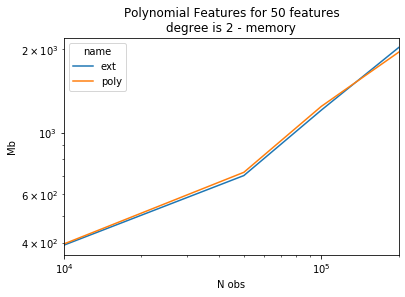

In [24]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 50 features\ndegree is 2 - memory")
ax.set_ylabel("Mb")
ax.set_xlabel("N obs");